In [19]:
from tools import *
%matplotlib notebook
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm import trange
import mastcasjobs

In [20]:
jobs = mastcasjobs.MastCasJobs(context='PanSTARRS_DR2')
name = 'test'
ps1_query = """
            select 
            o.raMean, o.decMean,o.gMeanPSFMag,o.rMeanPSFMag,
            o.iMeanPSFMag,o.zMeanPSFMag,o.yMeanPSFMag,
            o.gMeanPSFMagErr,o.rMeanPSFMagErr,
            o.iMeanPSFMagErr,o.zMeanPSFMagErr,o.yMeanPSFMagErr
            into mydb.[{dbname}]
            from fGetNearbyObjEq({ra},{dec},{rad}) x
            JOIN MeanObjectView o on o.ObjID=x.ObjId
            LEFT JOIN StackObjectAttributes AS soa ON soa.objID = x.objID
            WHERE o.nDetections > 5
            AND soa.primaryDetection > 0
            AND o.{band}MeanPSFMag < {maglim}
            """

In [71]:
data = pd.read_csv('K2_all_PS1_psc_ev_crowding_sdss_gaia_ext.csv')
data = data.iloc[(data['PDC'].values > 0)]

data['kMeanPSFMag'] = -2.5*np.log10(data['PDC'].values)
data['kMeanPSFMagErr'] = 0.01#(-2.5 / np.log(10)) * (data['PDCe'].values / data['PDC'].values) #0.05#np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)/10
#data = data.iloc[abs(data['kMeanPSFMagErr'].values) < 0.1] 
diff = abs(data['rMeanPSFMag'].values - data['crMeanPSFMag'].values)
ind = diff < 1

data = data.iloc[ind]

ind = ((abs(data['zMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['gMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['rMeanPSFMagErr'].values) < 0.5) & 
       (abs(data['iMeanPSFMagErr'].values) < 0.5))
data = data.iloc[ind]

ind = (data.campaign.values == 2)# & (data.Channel.values == 80)
data = data.iloc[ind]

In [64]:
dist2 = (data.RAJ2000.values[:,np.newaxis]-data.RAJ2000.values[np.newaxis,:])**2+ (data.DecJ2000.values[:,np.newaxis]-data.DecJ2000.values[np.newaxis,:])**2
dist = np.sqrt(dist2)

In [65]:
dist[dist==0] = np.nan

In [66]:
mindist = np.nanmin(dist,axis=1)

<IPython.core.display.Javascript object>


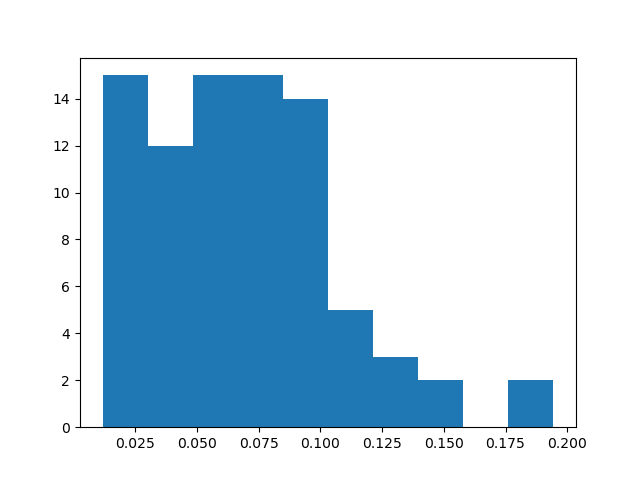

(array([15., 12., 15., 15., 14.,  5.,  3.,  2.,  0.,  2.]),
 array([0.01169796, 0.02996923, 0.0482405 , 0.06651177, 0.08478304,
        0.10305431, 0.12132558, 0.13959685, 0.15786812, 0.17613939,
        0.19441066]),
 <BarContainer object of 10 artists>)

In [67]:
plt.figure()
plt.hist(mindist)

In [68]:
ra = data.RAJ2000.values[0]
dec = data.DecJ2000.values[0]
query = ps1_query.format(dbname=name,ra=ra,
                          dec=dec,rad=.1*60,
                          band='g',maglim='19')
try:
    jobs.drop_table_if_exists(name)
except:
    pass
jobs.quick(query)
tab = jobs.get_table(name,format='CSV').to_pandas()

ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
       (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
tab = tab.iloc[ind]

<IPython.core.display.Javascript object>


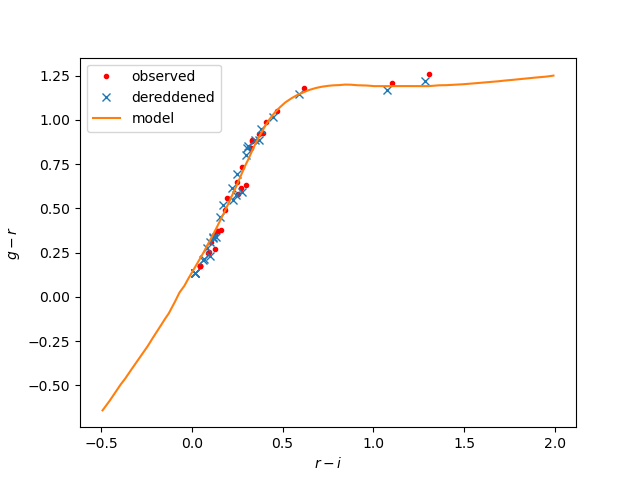

In [69]:
lowe,low = Tonry_reduce(tab,plot=True)

In [33]:
lowe

array([0.17563963])

In [46]:
lowe

array([0.1716241])

In [70]:
len(data)

83

In [73]:
from copy import deepcopy

In [75]:
dat = deepcopy(data)
dat['ext'] = np.nan


In [77]:

for i in trange(len(data)):
    ra = data.RAJ2000.values[i]
    dec = data.DecJ2000.values[i]
    query = ps1_query.format(dbname=name,ra=ra,
                              dec=dec,rad=.1*60,
                              band='g',maglim='19')
    try:
        jobs.drop_table_if_exists(name)
    except:
        pass
    jobs.quick(query)
    tab = jobs.get_table(name,format='CSV').to_pandas()

    ind = ((tab.gMeanPSFMag.values > -800) & (tab.rMeanPSFMag.values > -800) & 
           (tab.iMeanPSFMag.values > -800) & (tab.zMeanPSFMag.values > -800))
    tab = tab.iloc[ind]
    lowe,low = Tonry_reduce(tab,plot=False)
    dat['ext'].iloc[i] = lowe

  2%|▏         | 56/3393 [07:57<7:53:59,  8.52s/it]


KeyboardInterrupt: 

In [60]:
e=np.array(e)

In [61]:
e

array([[0.17163334],
       [0.1522958 ],
       [0.15175182],
       [0.17429205],
       [0.16580088],
       [0.20213188],
       [0.1708435 ],
       [0.16563686],
       [0.1917459 ],
       [0.21408674],
       [0.15043444],
       [0.15452645],
       [0.16509139],
       [0.15812991]])

In [58]:
len(low)

230

<IPython.core.display.Javascript object>


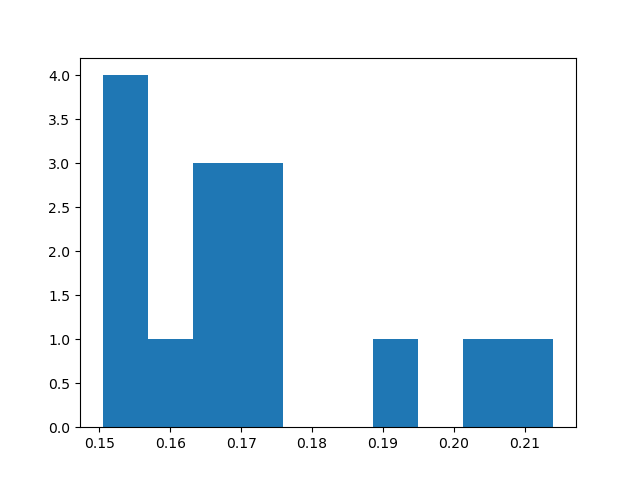

(array([4., 1., 3., 3., 0., 0., 1., 0., 1., 1.]),
 array([0.15043444, 0.15679967, 0.1631649 , 0.16953013, 0.17589536,
        0.18226059, 0.18862582, 0.19499105, 0.20135628, 0.20772151,
        0.21408674]),
 <BarContainer object of 10 artists>)

In [62]:
plt.figure()
plt.hist(e.flatten())